# Instructions

We've attached a dataset, [MNIST.mat](https://canvas.dartmouth.edu/files/10710316/download?download_frd=1), containing a sample of the famous MNIST benchmark.

Your report must provide summaries of each method's performance and some additional details of your implementation. Compare the relative strengths and weaknesses of the methods based on both the experimental results and your understanding of the algorithms.

You can load the data with `scipy.io.loadmat`, which will return a Python dictionary containing the test and train data and labels.

The purpose of this assignment is for you to implement the SVM.
You are not allowed to import an SVM from, for instance, `scikit-learn`.
You may, however, use a library (such as `scipy.optimize.minimize` or `cvxopt.solvers.qp`) for the optimization process.

In [97]:
import numpy as np
from scipy.io import loadmat
import cvxopt
import cvxopt.solvers
import copy

# drag and drop MNIST.mat in the files section of Google Colab
# the file should appear next to the default sample_data folder
mnist = loadmat('MNIST.mat')
test_samples = mnist['test_samples']
test_samples_labels = mnist['test_samples_labels']
train_samples = mnist['train_samples']
train_samples_labels = mnist['train_samples_labels']

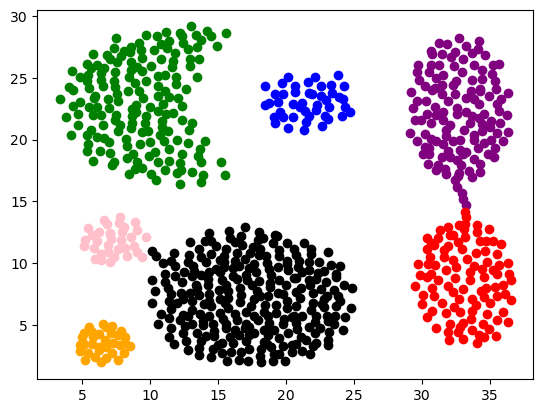

In [193]:
import pandas as pd
import matplotlib.pyplot as plt

# load the data
agg = pd.read_csv("aggregation.txt", sep="\t", header=None).values

# shuffle the data
np.random.shuffle(agg)

# split the data into train and test
train = agg[:650,:]
test = agg[650:,:]

# split the data into x and y
x_train = train[:,:2]
y_train = train[:,2]
x_test = test[:,:2]
y_test = test[:,2]

# plot the data; do different colors for each label
color_dic = {1:'blue', 2:'green', 3:'red', 4:'black', 5:'orange', 6:'purple', 7:'pink'}
for i in range(len(agg)):
    plt.plot(agg[i,0], agg[i,1], 'o', color=color_dic[agg[i,2]])

In [215]:
y_train

array([5., 4., 6., 4., 4., 2., 3., 2., 4., 2., 1., 3., 6., 4., 4., 2., 4.,
       2., 2., 3., 4., 1., 2., 4., 4., 6., 4., 4., 6., 4., 6., 4., 1., 4.,
       6., 2., 6., 1., 4., 2., 4., 2., 2., 2., 6., 2., 6., 4., 2., 4., 3.,
       3., 1., 1., 6., 6., 2., 2., 3., 5., 6., 4., 2., 6., 3., 6., 6., 4.,
       7., 4., 4., 3., 2., 4., 2., 4., 6., 7., 3., 2., 5., 3., 4., 2., 6.,
       4., 4., 5., 5., 2., 6., 2., 2., 2., 6., 4., 4., 6., 4., 2., 2., 3.,
       4., 6., 4., 7., 5., 4., 4., 6., 1., 3., 7., 4., 3., 4., 5., 5., 2.,
       4., 3., 2., 4., 4., 5., 6., 2., 1., 2., 5., 2., 4., 6., 4., 4., 3.,
       6., 3., 2., 4., 4., 3., 2., 3., 6., 2., 7., 2., 1., 6., 1., 4., 4.,
       4., 4., 5., 4., 4., 3., 4., 4., 6., 4., 4., 3., 1., 2., 3., 4., 6.,
       4., 3., 4., 3., 3., 2., 4., 2., 3., 3., 4., 3., 2., 6., 3., 2., 2.,
       4., 3., 3., 3., 2., 4., 4., 3., 4., 4., 4., 4., 6., 4., 2., 4., 6.,
       6., 2., 6., 3., 1., 2., 4., 4., 4., 2., 7., 2., 2., 6., 3., 2., 2.,
       4., 6., 2., 4., 4.

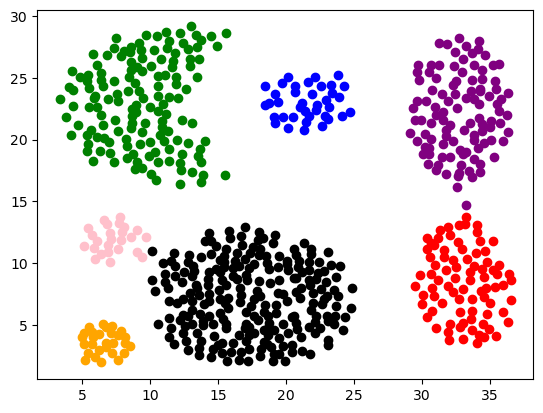

In [195]:
for i in range(len(x_train)):
    plt.plot(x_train[i,0], x_train[i,1], 'o', color=color_dic[y_train[i]])

(a) Develop code for training an SVM for binary classification with nonlinear kernels. You'll need to accomodate non-overlapping class distributions. One way to implement this is to maximize (7.32) subject to (7.33) and (7.34). It may be helpful to redefine these as matrix operations. Let ${1}\in\mathbb{R}^{N\times 1}$ be the vector whose entries are all 1's. Let $\mathbf{a}\in\mathbb{R}^{N\times 1}$ have entries $a_i$. Let $\mathbf{T}\in\mathbb{R}^{N\times N}$ be a diagonal matrix with $\mathbf{T}_{ii} = t_i$ on the diagonal. Then we can reformulate the objective to be

\begin{equation*}
\begin{aligned}
& \text{maximize}
& & \tilde{L}(\mathbf{a}) = {1}^{\mathrm{T}}\mathbf{a} - \frac{1}{2} \mathbf{a}^{\mathrm{T}} \mathbf{T}\mathbf{K} \mathbf{T}\mathbf{a} \\
& \text{subject to}
& & {1}^{\mathrm{T}} \mathbf{a} \preceq C \\
& & & {1}^{\mathrm{T}} \mathbf{a} \succeq 0 \\
& & & \mathbf{a}^{\mathrm{T}} \mathbf{t} = 0
\end{aligned}
\end{equation*}

The "$\preceq$" symbol here means element-wise comparison. This formulation is very close to what `cvxopt` expects.

Hint (`cvxopt` expects the following form):

\begin{equation*}
\begin{aligned}
& \text{minimize}
& & \tilde{L}(\mathbf{a}) = \frac{1}{2} \mathbf{a}^{\mathrm{T}} \mathbf{T}\mathbf{K} \mathbf{T}\mathbf{a} - {1}^{\mathrm{T}}\mathbf{a} \\
& \text{subject to}
& & G \mathbf{a} \preceq h \\
& & & {\mathbf{t}}^{\mathrm{T}}\mathbf{a} = 0
\end{aligned}
\end{equation*}

where $G$ is an $N\times N$ identity matrix ontop of $-1$ times an $N\times N$ identity matrix and $h \in\mathbb{R}^{2N}$ where the first $N$ entries are $C$ and the second $N$ enties are $0$.

(b) Develop code to predict the $\{-1,+1\}$ class for new data. To use the predictive model (7.13) you need to determine $b$, which can be done with (7.37).

In [145]:
def nonlinear_kernel(X1, X2, sigma):
    
  """
  Implement a nonlinear kernel function. Function parameters will vary depending on kernel function.
  For examle, you can try 

  Parameters
  ----------
  X : {array-like, sparse matrix} of shape (n_samples, n_features) or (n_samples, n_samples)
    Training vectors, where n_samples is the number of samples and n_features 
    is the number of features. For kernel=”precomputed”, the expected shape 
    of X is (n_samples, n_samples).

  y : array-like of shape (n_samples,)
    Target values (class labels in classification, real numbers in regression).
  """

  # rbf kernel; compute "closenss" between X1 and X2
  numerator = -np.linalg.norm(X1 - X2) ** 2
  denominator = 2 * sigma ** 2
  kernel = np.exp(numerator / denominator)
  
  return kernel

In [218]:
class SVM(object):

  def __init__(self, kernel=nonlinear_kernel, sigma=1.0, C=1.0, epsilon=1e-12):
    """
    Initialize SVM

    Parameters
    ----------
    kernel : callable
      Specifies the kernel type to be used in the algorithm. If none is given,
      ‘rbf’ will be used. If a callable is given it is used to pre-compute 
      the kernel matrix from data matrices; that matrix should be an array 
      of shape (n_samples, n_samples).
    C : float, default=1.0
      Regularization parameter. The strength of the regularization is inversely
      proportional to C. Must be strictly positive. The penalty is a squared l2
      penalty.
    """
    self.kernel = kernel
    self.sigma = sigma
    self.C = C
    self.epsilon = epsilon

  def fit(self, X, training_labels):
    """
    Fit the SVM model according to the given training data.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features) or (n_samples, n_samples)
      Training vectors, where n_samples is the number of samples and n_features 
      is the number of features. For kernel=”precomputed”, the expected shape 
      of X is (n_samples, n_samples).

    y : array-like of shape (n_samples,)
      Target values (class labels in classification, real numbers in regression).

    Returns
    -------
    self : object
      Fitted estimator.
    """
    # Hint:
    # 1. Define Quadratic Programming (QP) parameters. Given a QP optimization 
    #    problem in standard form, cvxopt is looking for P, q, G, h, A, and b
    #    (https://cvxopt.org/userguide/coneprog.html#quadratic-cone-programs).
    # 2. Construct the QP, invoke solver (use cvxopt.solvers.qp to maximize the Lagrange (7.32))
    # 3. Extract optimal value and solution. cvxopt.solvers.qp(P, q, G, h, A, b)["x"] are the Lagrange multipliers.

    # P is a square dense or sparse real matrix, representing a positive semidefinite symmetric matrix in 'L' storage, i.e., only the lower triangular part of P is referenced. q is a real single-column dense matrix.

    # cleaning up the samples and labels
    y = np.copy(training_labels)
    y = y.reshape(y.shape[0])
    self.y = y
    self.X = X
    n = X.shape[0]

    y = y.astype(float)
    T = np.diag(y.reshape(y.shape[0]))
    K = np.zeros((X.shape[0], X.shape[0]))

    # compute kernel matrix
    for i, X1 in enumerate(X):
      for j, X2 in enumerate(X):
        if j < i:
          K[i, j] = K[j, i]
        else:
          K[i, j] = self.kernel(X1, X2, sigma=self.sigma)

    P = cvxopt.matrix(np.matmul(np.matmul(T, K), T))
    q = cvxopt.matrix(-np.ones((n, 1), dtype=float))
    G = cvxopt.matrix(np.vstack((np.identity(n, dtype=float), -np.identity(n, dtype=float))))
    h = np.concatenate((np.full(n, self.C, dtype=float), np.zeros(n, dtype=float)))
    h = cvxopt.matrix(h.reshape((h.shape[0], 1)))
    A = cvxopt.matrix(y.reshape((n, 1)).transpose())
    b = cvxopt.matrix(np.zeros((1, 1), dtype=float))

    # solve the QP problem
    self.alphas = cvxopt.solvers.qp(P, q, G, h, A, b)["x"]
    self.alphas = np.array(self.alphas).reshape(n)
    self.weights = np.zeros(X.shape[1], dtype=float)

    # make sure alphas are not too small (~0)
    for i in range(n):
      if self.alphas[i] > self.epsilon:
        # this can be used for prediction
        self.weights += X[i] * y[i] * self.alphas[i]
      else:
        self.alphas[i] = 0.0

    print("should be 0: ", np.dot(self.alphas, y))
    
    print("weights: ", self.weights.shape)
    print(self.weights)

    print("alphas: ", self.alphas.shape)
    for i in range(len(self.alphas)):
      print(i, ": ", self.alphas[i])

    classPos = X[y > 0]
    classNeg = X[y < 0]

    # calculate bias
    self.bias = -1/2 * (np.dot(classPos, self.weights).min() + np.dot(classNeg, self.weights).max())
    
    return self

  def predict(self, X):
    """
    Perform classification on samples in X.

    For an one-class model, +1 or -1 is returned.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features) or (n_samples_test, n_samples_train)

    Returns
    -------
    y_pred : ndarray of shape (n_samples,)
      Class labels for samples in X.
    """

    score_pred = np.zeros(X.shape[0])  # to store the score of each sample
    y_pred = np.zeros(X.shape[0])  # to store the predicted label of each sample
    
    for i, x in enumerate(X):
      score_pred[i] = self.bias
      for j, x_train in enumerate(self.X):
        score_pred[i] += self.alphas[j] * self.y[j] * self.kernel(x, x_train, self.sigma)
      
      print("score_pred: ", score_pred[i])
      y_pred[i] = np.sign(score_pred[i])

    return y_pred, score_pred

  def score(self, X, y):
    """
    Return the mean accuracy on the given test data and labels. 
    
    In multi-label classification, this is the subset accuracy which is a harsh 
    metric since you require for each sample that each label set be correctly 
    predicted.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
      Test samples.
    y : array-like of shape (n_samples,) or (n_samples, n_outputs)
      True labels for X.

    Return
    ------
    score : float
      Mean accuracy of self.predict(X)
    """

    y_pred = self.predict(X)[0]
    print(y)
    print(y_pred)
    score = np.mean(y == y_pred)
    
    return score

(c) Using your implementation, compare multiclass classification performance of two different voting schemes:

* one versus rest
* one versus one

In [216]:
def one_versus_rest(train_samp, train_lab, test_samp, test_lab, kernel, sigma, C, epsilon=10e-5, classes=range(10)):
    # split the problem into 10 binary classification problems; 0 versus all others, 1 versus all others, etc

    scores = np.zeros((test_samp.shape[0], 10))

    # train 10 SVMs, one for each binary classification problem
    for i in classes:
      print("Training SVM for class", i)

      train_lab_local = copy.deepcopy(train_lab)
      test_lab_local = copy.deepcopy(test_lab)
      
      # transform labels
      train_lab_local = np.where(train_lab_local == i, 1, -1)
      test_lab_local = np.where(test_lab_local == i, 1, -1)


      print("train_lab: ", train_lab.shape)
      print("{} samples in class {}".format(np.count_nonzero(train_lab_local == 1), i))
      print("{} samples in class not {}".format(np.count_nonzero(train_lab_local == -1), i))

      # train SVM
      svm = SVM(kernel=kernel, sigma=sigma, C=C, epsilon=epsilon)
      svm.fit(train_samp, train_lab_local)

      # predict the test data using this SVM and store the scores
      y_predictions, score_pred = svm.predict(test_samp)
      scores[:, i] = score_pred

      print("test_lab: ", test_lab.shape)
      print("{} samples in class {}".format(np.count_nonzero(test_lab_local == 1), i))
      print("{} samples in class not {}".format(np.count_nonzero(test_lab_local == -1), i))

      print("------------------------------------")
      print("score for one vs rest: ", svm.score(test_samp, test_lab_local))
      print("------------------------------------")

      print()
    
    # predict the class with the highest score
    predictions = np.argmax(scores, axis=1)

    # compare to test labels
    acc = np.mean(predictions == test_lab)

    return acc, scores, predictions


In [ ]:
def one_versus_one():
    # split the problem into even more binary classification problems; 0 versus class 1, class 0 versus class 2, etc.
    # train 45 SVMs, one for each binary classification problem
    pass

(d) The parameter $C>0$ controls the tradeoff between the size of the margin and the slack variable penalty. It is analogous to the inverse of a regularization coefficient. Include in your report a brief discussion of how you found an appropriate value.

In [ ]:
model_accuracy, model_scores, model_preds = one_versus_rest(train_samples, train_samples_labels, test_samples, test_samples_labels, kernel=nonlinear_kernel, sigma=0.001, C=0.001)

print("model accuracy: ", model_accuracy)
print("model scores: ", model_scores)
print("model predictions: ", model_preds)

In [219]:
model_accuracy_toy, model_scores_toy, model_preds_toy = one_versus_rest(x_train, y_train, x_test, y_test, kernel=nonlinear_kernel, sigma=1.0, C=1.0, classes=range(1,8))

print("model accuracy: ", model_accuracy_toy)
print("model scores: ", model_scores_toy)
print("model predictions: ", model_preds_toy)

Training SVM for class 1
train_lab:  (650,)
38 samples in class 1
612 samples in class not 1
     pcost       dcost       gap    pres   dres
 0: -1.0405e+01 -7.0639e+02  7e+02  5e-14  7e-16
 1: -1.2798e+01 -6.8165e+01  6e+01  2e-15  6e-16
 2: -1.3638e+01 -2.2399e+01  9e+00  2e-15  2e-16
 3: -1.3883e+01 -1.6091e+01  2e+00  2e-15  9e-17
 4: -1.3973e+01 -1.4324e+01  4e-01  5e-15  8e-17
 5: -1.3996e+01 -1.4063e+01  7e-02  9e-16  7e-17
 6: -1.4003e+01 -1.4011e+01  8e-03  4e-15  9e-17
 7: -1.4004e+01 -1.4006e+01  2e-03  2e-15  9e-17
 8: -1.4005e+01 -1.4005e+01  3e-04  3e-15  7e-17
 9: -1.4005e+01 -1.4005e+01  5e-05  2e-16  7e-17
10: -1.4005e+01 -1.4005e+01  4e-06  3e-15  7e-17
Optimal solution found.
should be 0:  0.0013428033810873874
weights:  (2,)
[ 27.70983604 118.22791048]
alphas:  (650,)
0 :  0.0
1 :  0.0
2 :  0.0
3 :  0.0871452402050998
4 :  0.0
5 :  0.0987891260921539
6 :  0.004870799054153008
7 :  0.0
8 :  0.0
9 :  0.058471564830944
10 :  0.9999999164011001
11 :  0.0
12 :  0.0054472

In [ ]:
# Hint: Try using np.logspace for hyperparameter tuning

C_opts = np.logspace(1, 3, 10)
for c in C_opts:
    print("C = {}".format(c))
    one_versus_rest(train_samples, train_samples_labels, test_samples, test_samples_labels, kernel=nonlinear_kernel, C=c)
    print()

(e) In addition to calculating percent accuracy, generate multiclass [confusion matrices](https://en.wikipedia.org/wiki/confusion_matrix) as part of your analysis.

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

preds = svm.predict(test_samples)
ConfusionMatrixDisplay.from_predictions(test_samples_labels, preds)
